In [ ]:
# mounting the google drive where the data csv files downloaded
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import pandas as pd
import numpy as np
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from xgboost import XGBClassifier

In [ ]:
# credits to Kaggle for the data csv files
# URL: https://www.kaggle.com/c/ieee-fraud-detection/data

# Loading transaction data from csv file
tran_data_path = '/gdrive/My Drive/AIML/Project/train_transaction.csv'
# Reading data into pandas dataframe
tran_df = pd.read_csv(tran_data_path)
# Loading identity data from csv file
id_data_path = '/gdrive/My Drive/AIML/Project/train_identity.csv'
# Reading data into pandas dataframe
id_df = pd.read_csv(id_data_path)

print("Training Data:")
print("Transaction data shape:", tran_df.shape)
print("Identity data shape:", id_df.shape)

Training Data:
Transaction data shape: (590540, 394)
Identity data shape: (144233, 41)


In [ ]:
train_data = tran_df.merge(id_df, how='left', left_index=True, right_index=True)
print("Training Merged Data Shape:", train_data.shape)

Training Merged Data Shape: (590540, 435)


In [ ]:
# Loading Test transaction data from csv file
test_tran_data_path = '/gdrive/My Drive/AIML/Project/test_transaction.csv'
# Reading data into pandas dataframe
test_tran_df = pd.read_csv(test_tran_data_path)
# Loading Test identity data from csv file
test_id_data_path = '/gdrive/My Drive/AIML/Project/test_identity.csv'
# Reading data into pandas dataframe
test_id_df = pd.read_csv(test_id_data_path)

# Reading the sample submission csv file
#sample_submission = pd.read_csv('/gdrive/My Drive/AIML/Project/sample_submission.csv')

print("Testing Data:")
print("Test Transaction data shape:", test_tran_df.shape)
print("Test Identity data shape:", test_id_df.shape)

Testing Data:
Test Transaction data shape: (506691, 393)
Test Identity data shape: (141907, 41)


In [ ]:
test_data = test_tran_df.merge(test_id_df, how='left', left_index=True, right_index=True)
print("Testing Merged Data Shape:", test_data.shape)

Testing Merged Data Shape: (506691, 434)


In [ ]:
test_data.columns

Index(['TransactionID_x', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [ ]:
# Adding a new column in training data for k-fold
train_data["kfold"] = -1

for col in train_data.columns:
  print(col, train_data[col].dtype)

TransactionID_x int64
isFraud int64
TransactionDT int64
TransactionAmt float64
ProductCD object
card1 int64
card2 float64
card3 float64
card4 object
card5 float64
card6 object
addr1 float64
addr2 float64
dist1 float64
dist2 float64
P_emaildomain object
R_emaildomain object
C1 float64
C2 float64
C3 float64
C4 float64
C5 float64
C6 float64
C7 float64
C8 float64
C9 float64
C10 float64
C11 float64
C12 float64
C13 float64
C14 float64
D1 float64
D2 float64
D3 float64
D4 float64
D5 float64
D6 float64
D7 float64
D8 float64
D9 float64
D10 float64
D11 float64
D12 float64
D13 float64
D14 float64
D15 float64
M1 object
M2 object
M3 object
M4 object
M5 object
M6 object
M7 object
M8 object
M9 object
V1 float64
V2 float64
V3 float64
V4 float64
V5 float64
V6 float64
V7 float64
V8 float64
V9 float64
V10 float64
V11 float64
V12 float64
V13 float64
V14 float64
V15 float64
V16 float64
V17 float64
V18 float64
V19 float64
V20 float64
V21 float64
V22 float64
V23 float64
V24 float64
V25 float64
V26 float64
V27

In [ ]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=36)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=train_data)):
    train_data.loc[valid_indicies, "kfold"] = fold

train_data.to_csv("/gdrive/My Drive/AIML/Project/training_folds.csv", index=False)

In [ ]:
del tran_df
del id_df
#del test_tran_df
#del test_id_df

In [ ]:
import gc
gc.collect()

train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/training_folds.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (406,409,410,417,421,422,423,424,425,427,428,429,430,431,432,433,434) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# excluding the columns with object as dtype
category_cols = train_data.select_dtypes(include=['object']).columns
category_cols

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [ ]:
x_numerical_cols = train_data.select_dtypes(exclude=['object']).columns
x_numerical_cols

Index(['TransactionID_x', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26',
       'id_32', 'kfold'],
      dtype='object', length=405)

In [ ]:
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]
len(useful_cols)

432

In [ ]:
y_numerical_cols = test_data.select_dtypes(exclude=['object']).columns
y_numerical_cols

Index(['TransactionID_x', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card5', 'addr1', 'addr2', 'dist1',
       ...
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32'],
      dtype='object', length=403)

In [ ]:
import gc
gc.collect()

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
category_cols = train_data.select_dtypes(include=['object']).columns
for col in category_cols:
    label_encoder.fit(list(train_data[col].astype(str).values)+list(test_data[col].astype(str).values))
    train_data[col] = label_encoder.transform(list(train_data[col].astype(str).values))
    
train_data.fillna(-999,inplace=True)

train_data.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,kfold
0,2987000,0,86400,68.5,9,13926,-999.0,150.0,6,142.0,4,315.0,87.0,19.0,-999.0,92,91,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,70787.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,100.0,2,-999.0,-480.0,2,2,166.0,-999.0,542.0,144.0,-999.0,-999.0,4,-999.0,-999.0,-999.0,3,2,2,8,125,32.0,164,4,2,1,2,2,2,955,2
1,2987001,0,86401,29.0,9,2755,404.0,150.0,7,102.0,4,325.0,87.0,-999.0,-999.0,76,91,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,98945.0,-999.0,-999.0,0.0,-5.0,-999.0,-999.0,-999.0,-999.0,100.0,2,49.0,-300.0,2,2,166.0,-999.0,621.0,500.0,-999.0,-999.0,4,-999.0,-999.0,-999.0,3,2,2,64,99,32.0,48,3,2,1,1,2,2,1728,0
2,2987002,0,86469,59.0,9,4663,490.0,150.0,9,166.0,5,330.0,87.0,287.0,-999.0,96,91,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,191631.0,0.0,0.0,0.0,0.0,-999.0,-999.0,0.0,0.0,100.0,2,52.0,-999.0,1,1,121.0,-999.0,410.0,142.0,-999.0,-999.0,4,-999.0,-999.0,-999.0,3,1,1,75,45,-999.0,261,5,1,1,2,2,1,1599,0
3,2987003,0,86499,50.0,9,18132,567.0,150.0,7,117.0,5,476.0,87.0,-999.0,-999.0,114,91,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,-999.0,-999.0,-999.0,-999.0,...,221832.0,-999.0,-999.0,0.0,-6.0,-999.0,-999.0,-999.0,-999.0,100.0,2,52.0,-999.0,2,2,225.0,-999.0,176.0,507.0,-999.0,-999.0,4,-999.0,-999.0,-999.0,3,2,2,75,45,-999.0,261,5,1,1,2,2,1,1743,2
4,2987004,0,86506,50.0,6,4497,514.0,150.0,7,102.0,4,420.0,87.0,-999.0,-999.0,76,91,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,7460.0,0.0,0.0,1.0,0.0,-999.0,-999.0,0.0,0.0,100.0,2,-999.0,-300.0,1,1,166.0,15.0,529.0,575.0,-999.0,-999.0,4,-999.0,-999.0,-999.0,3,1,1,25,45,24.0,40,4,2,1,2,2,1,724,2


In [ ]:
idx = int(train_data.shape[0] * 0.8)
print(idx)
test_data = train_data [idx:]
train_data = train_data [:idx]
print(train_data.shape, test_data.shape)
train_data.to_csv("/gdrive/My Drive/AIML/Project/training_final.csv", index=False)
test_data.to_csv("/gdrive/My Drive/AIML/Project/test_final.csv", index=False)

472432
(472432, 436) (118108, 436)


In [ ]:
%%time

train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")

final_valid_predictions = {}
scores = []

for fold in range(3):
    x_train =  train_data[train_data.kfold != fold].reset_index(drop=True)
    x_valid = train_data[train_data.kfold == fold].reset_index(drop=True)

    valid_ids = x_valid.TransactionID_x.values.tolist()
    
    y_train = x_train.isFraud
    y_valid = x_valid.isFraud
    

    x_train = x_train[useful_cols]
    x_valid = x_valid[useful_cols]
       
    model2 = RandomForestClassifier(random_state=fold, n_jobs=-1, class_weight='balanced')
    model2.fit(x_train, y_train)
    preds_valid = model2.predict(x_valid)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    ROC_score = roc_auc_score(y_valid, preds_valid)
    print(fold, ROC_score)
    scores.append(ROC_score)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_2"]
final_valid_predictions.to_csv("/gdrive/My Drive/AIML/Project/train_pred_2.csv", index=False)

0 0.7016582865452373
1 0.6997553459880308
2 0.7039615889516302
0.7017917404949662 0.0017197824348312225
CPU times: user 14min 51s, sys: 10.5 s, total: 15min 1s
Wall time: 8min 13s


In [ ]:
def plot_confusion_matrix(y_actual, y_pred):
    #Get the confusion matrix, Precision & Re-call
    conf_matrix = confusion_matrix(y_actual, y_pred)
    recal_matrix =(((conf_matrix.T)/(conf_matrix.sum(axis=1))).T)        
    prec_matrix =(conf_matrix/conf_matrix.sum(axis=0))

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(prec_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(recal_matrix, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

In [ ]:
final_test_pred = {}
test_ids = test_data.TransactionID_x.values.tolist()
y_actual = test_data.isFraud
x_test = test_data[useful_cols]
test_preds = model2.predict(x_test)
final_test_pred.update(dict(zip(test_ids,test_preds)))
final_test_pred = pd.DataFrame.from_dict(final_test_pred, orient="index").reset_index()
final_test_pred.columns = ["id", "pred_2"]
final_test_pred['Actual'] = y_actual.values
final_test_pred.to_csv("/gdrive/My Drive/AIML/Project/test_pred_2.csv", index=False)

ROC_score = roc_auc_score(final_test_pred.Actual, final_test_pred.pred_2)
print('Test ROC Score: ', ROC_score)

Test ROC Score:  0.6223738551524663


Test confusion_matrix


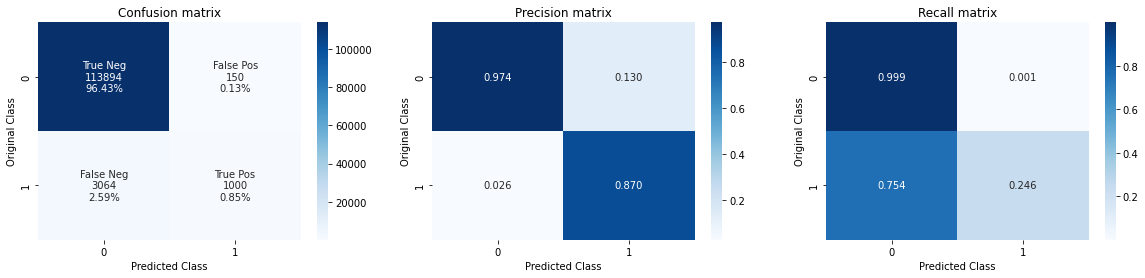

In [ ]:
print('Test confusion_matrix')
plot_confusion_matrix(final_test_pred.Actual, final_test_pred.pred_2)

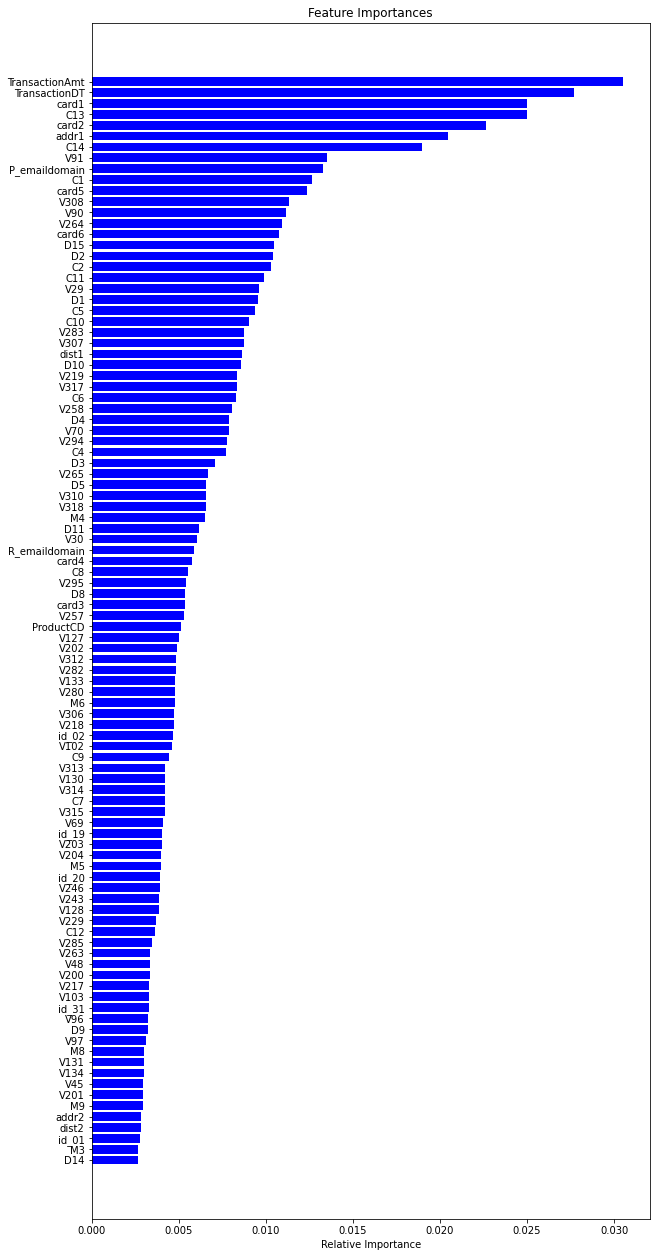

In [ ]:
features = x_train.columns
importances = model2.feature_importances_
indices = (np.argsort(importances))[-100:]
plt.figure(figsize=(10,22))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Estimators =  10 Train Score 0.8437324130168552 test Score 0.7853479184508702
Estimators =  50 Train Score 0.8483543817956208 test Score 0.789141436327794
Estimators =  100 Train Score 0.8494057940886849 test Score 0.7908156502725707
Estimators =  250 Train Score 0.8499708620656027 test Score 0.7890088207079626
Estimators =  500 Train Score 0.8500421601067712 test Score 0.789575479328741
Estimators =  1000 Train Score 0.8502662634164415 test Score 0.7882007552272269


Text(0.5, 1.0, 'Estimators vs score at depth of 15')

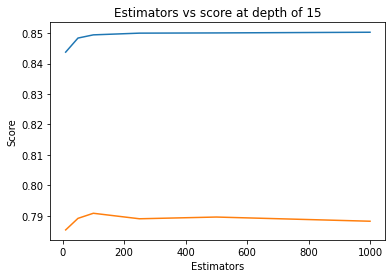

In [ ]:
estimators = [10,50,100,250,500, 1000]
train_scores = []
test_scores = []

x_train = train_data[useful_cols].reset_index(drop=True)
y_train = train_data.isFraud

x_test = test_data[useful_cols].reset_index(drop=True)
y_test = test_data.isFraud

for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=2022,verbose=0,warm_start=False)
    clf.fit(x_train,y_train)
    train_sc = roc_auc_score(y_train,clf.predict(x_train))
    test_sc = roc_auc_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 15')

depth =  3 Train Score 0.7531123225705406 test Score 0.7530132295257226
depth =  9 Train Score 0.8090459190611452 test Score 0.7919924305013372
depth =  11 Train Score 0.8229322317428701 test Score 0.7861470772988018
depth =  15 Train Score 0.8496412879961707 test Score 0.7906970030492444
depth =  20 Train Score 0.8702092595654701 test Score 0.7863781232937583
depth =  35 Train Score 0.8821071496497312 test Score 0.7859989354847707
depth =  50 Train Score 0.881820268961144 test Score 0.7891618301003868
depth =  70 Train Score 0.881820268961144 test Score 0.7891618301003868
depth =  130 Train Score 0.881820268961144 test Score 0.7891618301003868
depth =  250 Train Score 0.881820268961144 test Score 0.7891618301003868


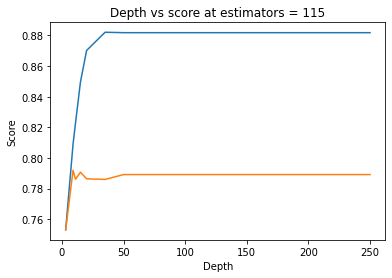

In [ ]:
depths = [3,9,11,15,20,35,50,70,130,250]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=2022,verbose=0,warm_start=False)
    clf.fit(x_train,y_train)
    train_sc = roc_auc_score(y_train,clf.predict(x_train))
    test_sc = roc_auc_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at estimators = 115')
plt.show()

In [ ]:
scores = []
final_valid_predictions={}

for fold in range(3):
    x_train =  train_data[train_data.kfold != fold].reset_index(drop=True)
    x_valid = train_data[train_data.kfold == fold].reset_index(drop=True)

    valid_ids = x_valid.TransactionID_x.values.tolist()
    
    y_train = x_train.isFraud
    y_valid = x_valid.isFraud
    

    x_train = x_train[useful_cols]
    x_valid = x_valid[useful_cols]
       
    model1 = XGBClassifier(random_state=fold, n_jobs=-1)
    model1.fit(x_train, y_train)
    preds_valid = model1.predict(x_valid)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    ROC_score = roc_auc_score(y_valid, preds_valid)
    print(fold, ROC_score)
    scores.append(ROC_score)

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_1"]
final_valid_predictions.to_csv("/gdrive/My Drive/AIML/Project/train_pred_1.csv", index=False)

0 0.6487102496969612
1 0.6467916510672247
2 0.6478909454876526
0.6477976154172795 0.0007860398853466278


In [ ]:
final_test_pred = {}
test_ids = test_data.TransactionID_x.values.tolist()
y_actual = test_data.isFraud
x_test = test_data[useful_cols]
test_preds = model1.predict(x_test)
final_test_pred.update(dict(zip(test_ids,test_preds)))
final_test_pred = pd.DataFrame.from_dict(final_test_pred, orient="index").reset_index()
final_test_pred.columns = ["id", "pred_1"]
final_test_pred['Actual'] = y_actual.values
final_test_pred.to_csv("/gdrive/My Drive/AIML/Project/test_pred_1.csv", index=False)

ROC_score = roc_auc_score(final_test_pred.Actual, final_test_pred.pred_1)
print('Test ROC Score: ', ROC_score)

Test ROC Score:  0.6340990963357974


Test confusion_matrix


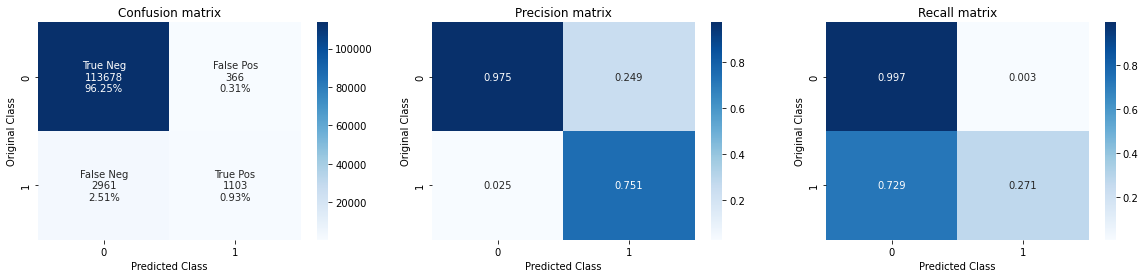

In [ ]:
print('Test confusion_matrix')
plot_confusion_matrix(final_test_pred.Actual, final_test_pred.pred_1)

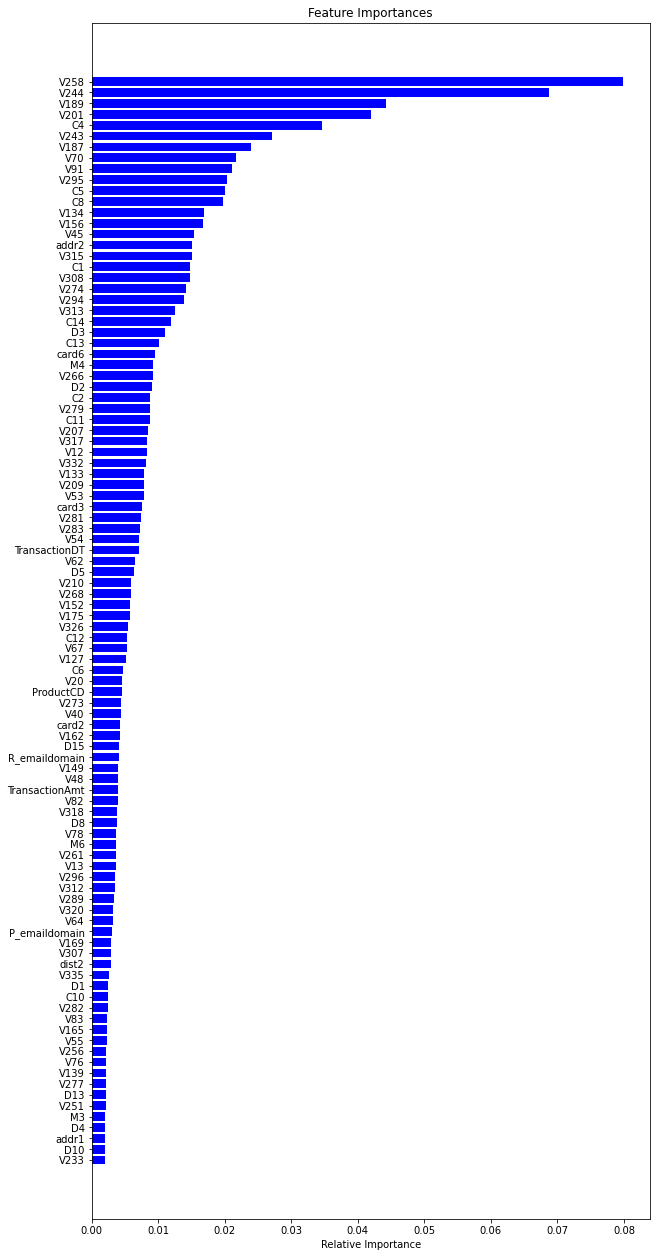

In [ ]:
features = x_train.columns
importances = model1.feature_importances_
indices = (np.argsort(importances))[-100:]
plt.figure(figsize=(10,22))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Estimators =  10 Train Score 0.7505373493753325 test Score 0.6426252467620592
Estimators =  50 Train Score 0.8754535852043711 test Score 0.6785748462328534
Estimators =  100 Train Score 0.9241635324693785 test Score 0.6799279208301148
Estimators =  250 Train Score 0.9627009186528406 test Score 0.6776865045456968


Text(0.5, 1.0, 'Estimators vs score at depth of 15')

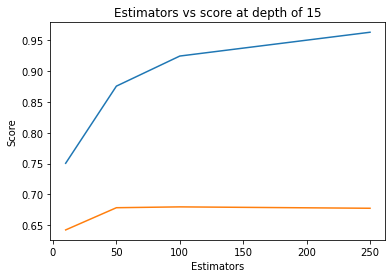

In [ ]:
estimators = [10,50,100,250]
train_scores = []
test_scores = []

train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")

x_train = train_data[useful_cols].reset_index(drop=True)
y_train = train_data.isFraud

x_test = test_data[useful_cols].reset_index(drop=True)
y_test = test_data.isFraud

for i in estimators:
    clf = XGBClassifier(max_depth=15, learning_rate = 0.1, max_leaf_nodes=None,
                        booster = 'gbtree', reg_alpha = 0, reg_lambda = 1, subsample = 1, 
                        colsample_bytree= 1, colsample_bylevel=1, colsample_bynode=1, 
                        n_estimators=i, n_jobs=-1,random_state=2022,verbose=0)
    clf.fit(x_train,y_train)
    train_sc = roc_auc_score(y_train,clf.predict(x_train))
    test_sc = roc_auc_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 15')

depth =  3 Train Score 0.6593471157984903 test Score 0.6349203146347437
depth =  9 Train Score 0.8027347326420439 test Score 0.680837912021524
depth =  21 Train Score 0.9738226274278012 test Score 0.6835610545881311
depth =  50 Train Score 0.9995180432556179 test Score 0.6803586324742183
depth =  100 Train Score 0.9998493885173806 test Score 0.6828889015622371


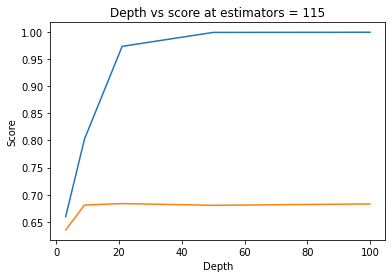

In [ ]:
depths = [3,9,21,50,100]

train_data = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
useful_cols = [col for col in train_data.columns if col not in ("isFraud", "TransactionID_x", "TransactionID_y", "kfold")]
test_data = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")

x_train = train_data[useful_cols].reset_index(drop=True)
y_train = train_data.isFraud

x_test = test_data[useful_cols].reset_index(drop=True)
y_test = test_data.isFraud

train_scores = []
test_scores = []
for i in depths:
    clf = XGBClassifier(max_depth=i, learning_rate = 0.1, max_leaf_nodes=None,
                        booster = 'gbtree', reg_alpha = 0, reg_lambda = 1, subsample = 1, 
                        colsample_bytree= 1, colsample_bylevel=1, colsample_bynode=1, 
                        n_estimators=115, n_jobs=-1,random_state=2022,verbose=0)
    clf.fit(x_train,y_train)
    train_sc = roc_auc_score(y_train,clf.predict(x_train))
    test_sc = roc_auc_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at estimators = 115')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cleaned_df = pd.read_csv("/gdrive/My Drive/AIML/Project/training_final.csv")
test_df = pd.read_csv("/gdrive/My Drive/AIML/Project/test_final.csv")

neg, pos = np.bincount(cleaned_df['isFraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# You don't want the `Time` column.
cleaned_df.pop('TransactionDT')
cleaned_df.pop('kfold')
cleaned_df.pop('TransactionID_x')
cleaned_df.pop('TransactionID_y')
test_df.pop('TransactionDT')
test_df.pop('kfold')
test_df.pop('TransactionID_x')
test_df.pop('TransactionID_y')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('TransactionAmt')+eps)
test_df['Log Ammount'] = np.log(test_df.pop('TransactionAmt')+eps)

# Use a utility from sklearn to split and shuffle your dataset.
train_df, val_df = train_test_split(cleaned_df, test_size=0.2)


Examples:
    Total: 472432
    Positive: 16599 (3.51% of total)



In [ ]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('isFraud'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('isFraud'))
test_labels = np.array(test_df.pop('isFraud'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)


Training features shape: (377945, 431)
Validation features shape: (94487, 431)
Test features shape: (118108, 431)
Training labels shape: (377945,)
Validation labels shape: (94487,)
Test labels shape: (118108,)


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc', curve="ROC"),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(
          8, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(
          4, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
          bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 200
BATCH_SIZE = 4096

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                6912      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5

In [ ]:
model.predict(train_features[:10])

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

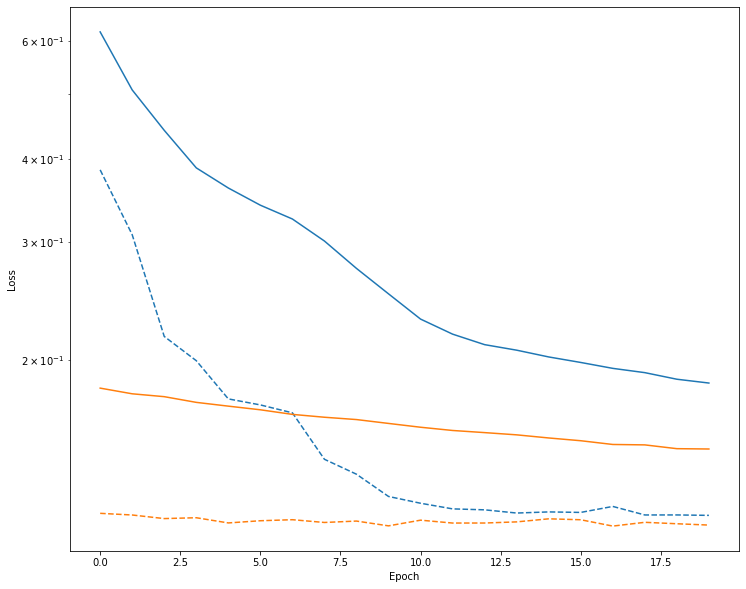

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/200
93/93 [==============================] - 5s 32ms/step - loss: 0.3668 - tp: 420.0000 - fp: 4138.0000 - tn: 451695.0000 - fn: 16179.0000 - accuracy: 0.9570 - precision: 0.0921 - recall: 0.0253 - auc: 0.5598 - prc: 0.0444 - val_loss: 0.2594 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 91215.0000 - val_fn: 3272.0000 - val_accuracy: 0.9654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7658 - val_prc: 0.0970
Epoch 2/200
93/93 [==============================] - 2s 18ms/step - loss: 0.3058 - tp: 7.0000 - fp: 45.0000 - tn: 364573.0000 - fn: 13320.0000 - accuracy: 0.9646 - precision: 0.1346 - recall: 5.2525e-04 - auc: 0.5250 - prc: 0.0387 - val_loss: 0.2149 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 91215.0000 - val_fn: 3272.0000 - val_accuracy: 0.9654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8035 - val_prc: 0.1608
Epoch 3/200
93/93 [==============================] - 2s 18ms/step - loss: 0.2751 - tp: 9.0000 - fp: 16.0000 - 

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

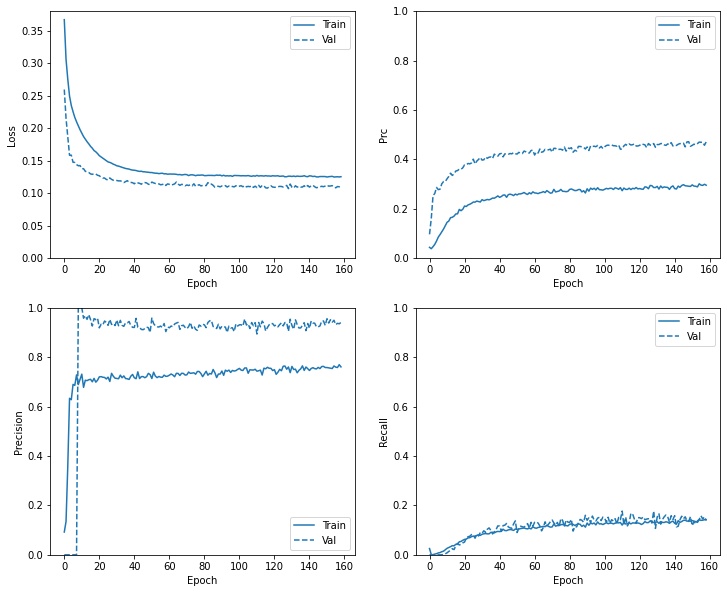

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.11764335632324219
tp :  415.0
fp :  113.0
tn :  113931.0
fn :  3649.0
accuracy :  0.9681478142738342
precision :  0.7859848737716675
recall :  0.10211614519357681
auc :  0.8409185409545898
prc :  0.36141133308410645



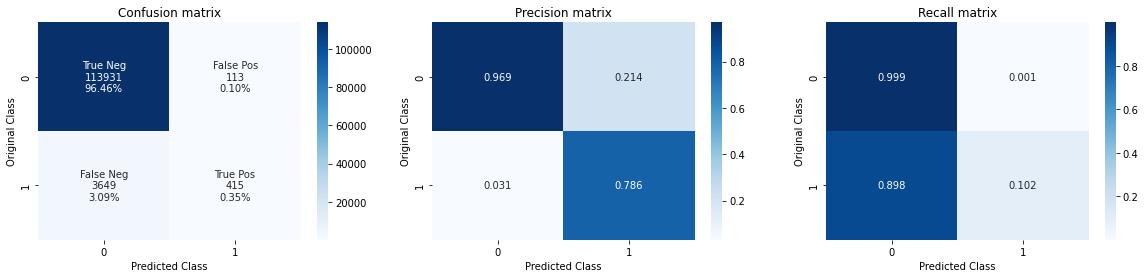

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

#plot_cm(test_labels, test_predictions_baseline)
plot_confusion_matrix(test_labels, test_predictions_baseline >0.5)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc_sc = sklearn.metrics.auc(fp, tp)
  #plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.plot(100*fp, 100*tp, label=name % auc_sc)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-5,105])
  plt.ylim([-5,105])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

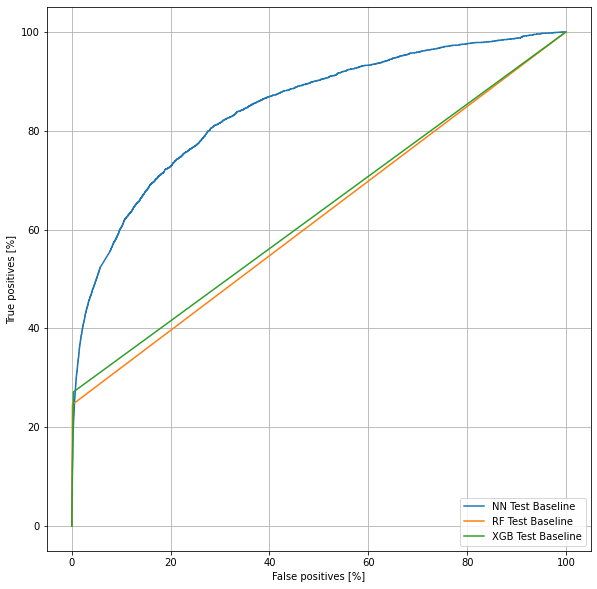

In [ ]:
#plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
final_test_pred= pd.read_csv("/gdrive/My Drive/AIML/Project/test_pred_2.csv")
plot_roc("RF Test Baseline", final_test_pred.Actual, final_test_pred.pred_2, color=colors[1], linestyle='--')
final_test_pred= pd.read_csv("/gdrive/My Drive/AIML/Project/test_pred_1.csv")
plot_roc("XGB Test Baseline", final_test_pred.Actual, final_test_pred.pred_1, color=colors[2], linestyle='--')

plt.legend(loc='lower right');
plt.show()